# Percent College Graduates Prediction
---
* Input: `'../data/census_tract_feats.csv'`
* Output: Regression model that predicts the percentage of the age 25+ population that has a college degree in a given census tract

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in original data
df = pd.read_csv('../data/census_tract_feats.csv')
df.head()

,geoID,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,...,"Pct. Households: $100,000 to $124,999","Pct. Households: $125,000 to $149,999","Pct. Households: $150,000 to $199,999","Pct. Households: $200,000 or More",Pct. Families below poverty level,Pct. Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Pct. Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling),Number of Accessible Universities,Education Desert
0,1001020100,1845,487.1106,899,1636,96,0,22,0,0,...,0.074271,0.079576,0.090186,0.021220,0.120287,0.106775,0.117073,0.223848,5,0
1,1001020200,2172,1684.0130,1167,913,1184,0,22,14,7,...,0.089400,0.040868,0.015326,0.000000,0.182903,0.224138,0.220588,0.444726,5,0
2,1001020300,3385,1638.9340,1533,2078,896,19,25,12,272,...,0.078968,0.039093,0.027365,0.000000,0.100363,0.146529,0.280650,0.427179,5,0
3,1001020400,4267,1731.4730,2001,3443,356,20,10,0,320,...,0.104631,0.032590,0.038308,0.005146,0.014617,0.022967,0.182564,0.205531,5,0
4,1001020500,9965,2264.4190,5054,7817,1638,0,305,0,0,...,0.178827,0.048164,0.054125,0.020029,0.084132,0.122349,0.133108,0.255457,5,0


In [2]:
# Count education deserts (1), non education deserts (0)
df['Education Desert'].value_counts()

0    63515
1    10230
Name: Education Desert, dtype: int64

In [3]:
# select columns to keep

# label features (sum these up)
bach_and_up_feats = ["Pct. Population 25 Years and Over: Bachelor's Degree",
    "Pct. Population 25 Years and Over: Master's Degree",
    'Pct. Population 25 Years and Over: Professional School Degree',
    'Pct. Population 25 Years and Over: Doctorate Degree'
]

# training features
train_feats = [
    'geoID',
    
    # demographics
    'Total Population:',
    'Population Density (Per Sq. Mile)',
    'Pct. Male', 'Pct. White Alone', 'Pct. Black or African American Alone', 'Pct. American Indian and Alaska Native Alone', 'Pct. Asian Alone', 'Pct. Native Hawaiian and Other Pacific Islander Alone', 'Pct. Some Other Race Alone', 'Pct. Two or More Races', 
    'Pct. Under 5 Years', 'Pct. 5 to 9 Years', 'Pct. 10 to 14 Years', 'Pct. 15 to 17 Years', 'Pct. 18 to 24 Years', 'Pct. 25 to 34 Years', 'Pct. 35 to 44 Years', 'Pct. 45 to 54 Years', 'Pct. 55 to 64 Years', 'Pct. 65 to 74 Years', 'Pct. 75 to 84 Years', 'Pct. 85 Years and Over',
    
    # education - omit post-college features (leakage)
    'Pct. Students enrolled in private school',
    
    # employment
    'Pct. Pop 16+ not in labor force',
    'Pct. Pop 16+ in armed forces',
    'Pct. Pop 16+ unemployed',
    
    # household income
    'Median Gross Rent',
    'Median Household Income (In 2017 Inflation Adjusted Dollars)',
    'Pct. Households: Less than $10,000', 'Pct. Households: $10,000 to $14,999', 'Pct. Households: $15,000 to $19,999', 'Pct. Households: $20,000 to $24,999', 'Pct. Households: $25,000 to $29,999', 'Pct. Households: $30,000 to $34,999', 'Pct. Households: $35,000 to $39,999', 'Pct. Households: $40,000 to $44,999', 'Pct. Households: $45,000 to $49,999', 'Pct. Households: $50,000 to $59,999', 'Pct. Households: $60,000 to $74,999', 'Pct. Households: $75,000 to $99,999', 'Pct. Households: $100,000 to $124,999', 'Pct. Households: $125,000 to $149,999', 'Pct. Households: $150,000 to $199,999', 'Pct. Households: $200,000 or More', 
    
    # poverty
    'Pct. Families below poverty level', 'Pct. Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly)', 'Pct. Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling)', 'Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling)',
    
    # education desert
    'Education Desert'
]

# Only keep selected features
df_train = df[train_feats + bach_and_up_feats]

# only keep non-education deserts -- education oases? (these are the census blocks we want to regress on)
df_deserts = df_train[df_train['Education Desert'] == 1].reset_index(drop=True)
df_nondeserts = df_train[df_train['Education Desert'] == 0].reset_index(drop=True)

# Get training data (all census tracts)
X_all = df_train.drop(labels=bach_and_up_feats, axis=1)
y_all = pd.Series(sum([df_train[feat] for feat in bach_and_up_feats]))

# Get training data (non education deserts)
X_nondesert = df_nondeserts.drop(labels=([] + bach_and_up_feats), axis=1)
y_nondesert = pd.Series(sum([df_nondeserts[feat] for feat in bach_and_up_feats]))

# Get prediction data (education deserts)
X_desert = df_deserts.drop(labels=[] + bach_and_up_feats, axis=1)
X_desert_intervention = X_desert.copy()
X_desert_intervention['Education Desert'] = 0
y_desert = pd.Series(sum([df_deserts[feat] for feat in bach_and_up_feats]))

print('X_all shape: ', X_all.shape)
print('y_all shape: ', y_all.shape)
print()
print('X_nondeserts shape: ', X_nondesert.shape)
print('y_nondeserts shape: ', y_nondesert.shape)
print()
print('X_deserts shape: ', X_desert.shape)
print('y_deserts shape: ', y_desert.shape)


X_all shape:  (73745, 50)
y_all shape:  (73745,)

X_nondeserts shape:  (63515, 50)
y_nondeserts shape:  (63515,)

X_deserts shape:  (10230, 50)
y_deserts shape:  (10230,)

X_balanced shape:  (20460, 50)
y_balanced shape:  (20460,)


In [ ]:
# Get balanced dataset (equal num. deserts, non-deserts)
def get_balanced_dataset(df_train):
    sampled_nondesert_inds = np.random.choice(df_train.loc[df_train['Education Desert'] == 0].index.values, 
                                         df_train.loc[df_train['Education Desert'] == 1].shape[0])
    desert_inds = df_train.loc[df_train['Education Desert'] == 1].index.values
    sampled_inds = np.hstack([sampled_nondesert_inds, desert_inds])
    df_balanced = df_train.loc[sampled_inds]
    X_balanced = df_balanced.drop(labels=([] + bach_and_up_feats), axis=1)
    y_balanced = pd.Series(sum([df_balanced[feat] for feat in bach_and_up_feats]))
    return X_balanced, y_balanced

X_balanced, y_balanced = get_balanced_dataset(df_train)

print('X_balanced shape: ', X_balanced.shape)
print('y_balanced shape: ', y_balanced.shape)

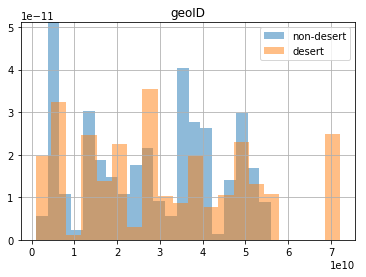

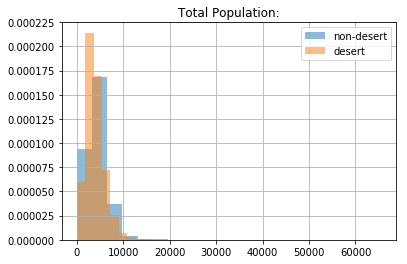

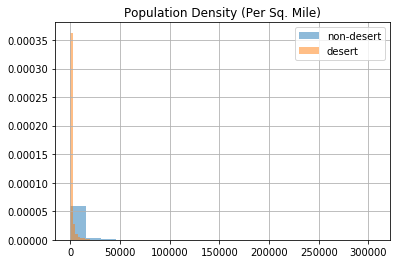

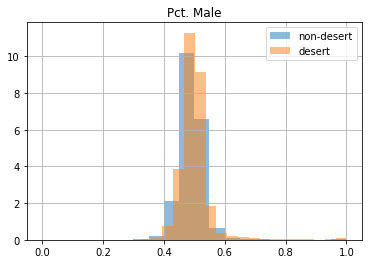

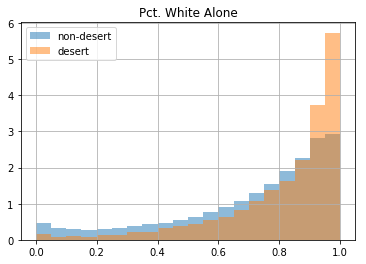

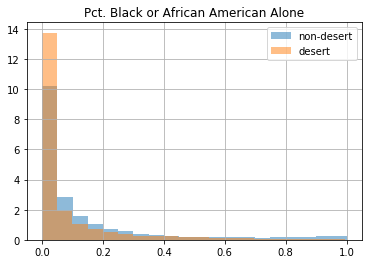

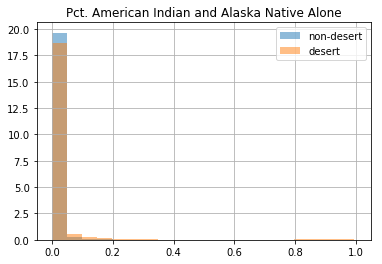

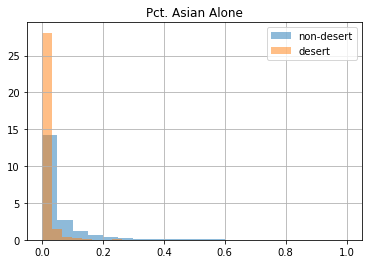

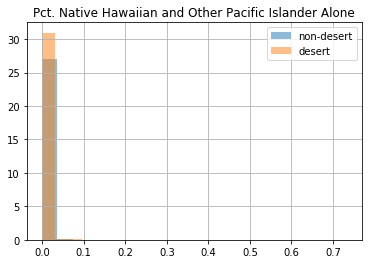

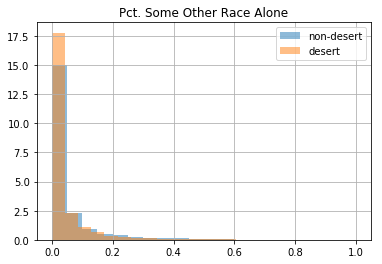

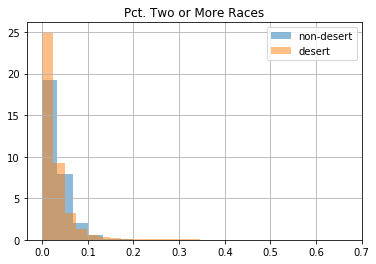

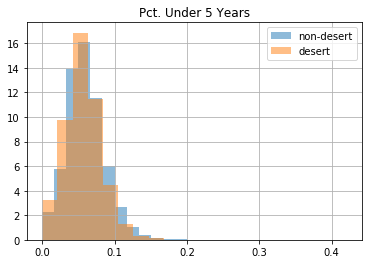

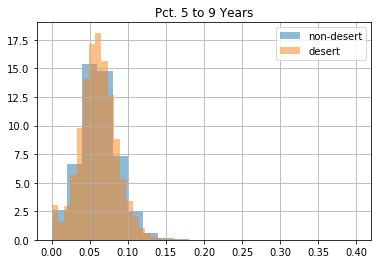

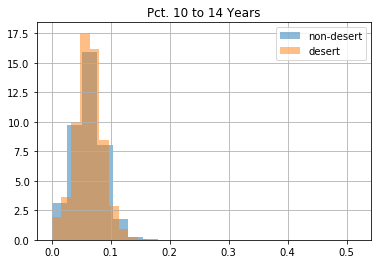

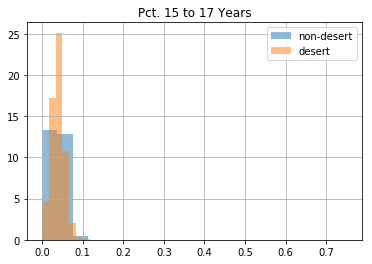

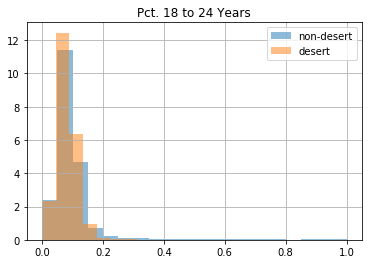

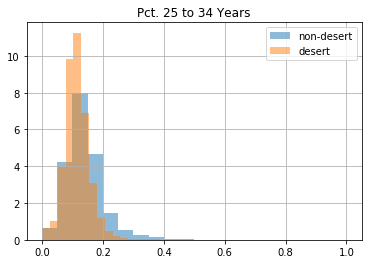

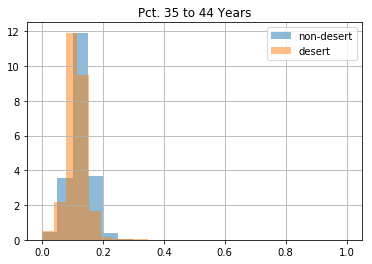

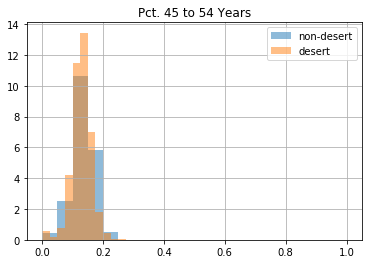

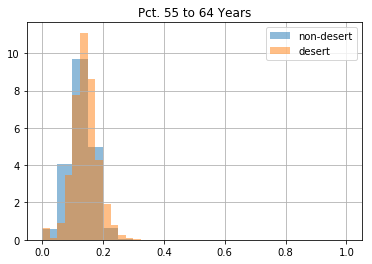

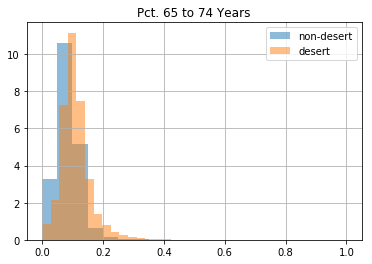

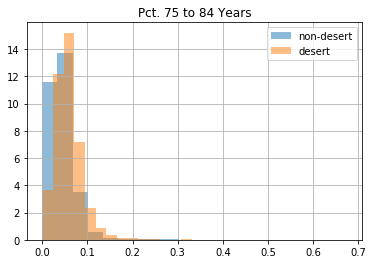

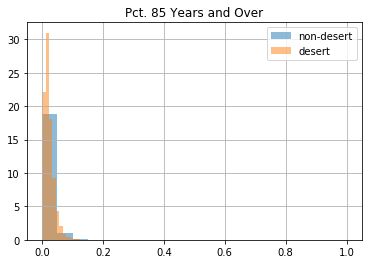

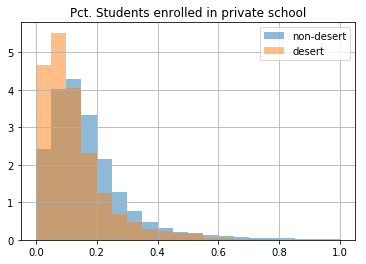

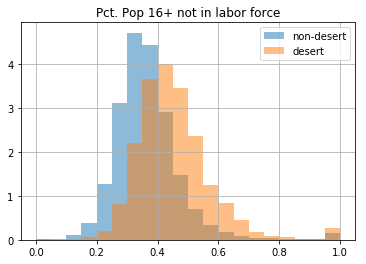

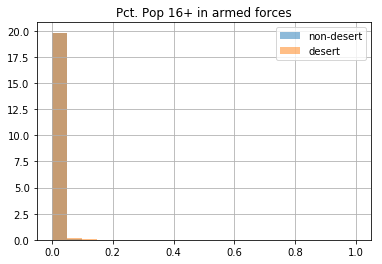

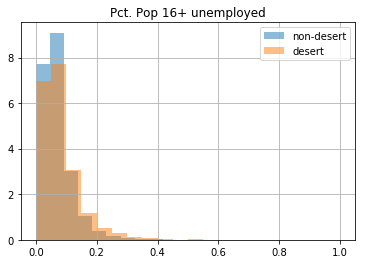

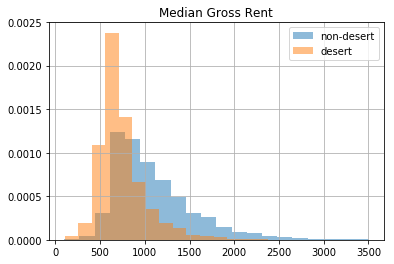

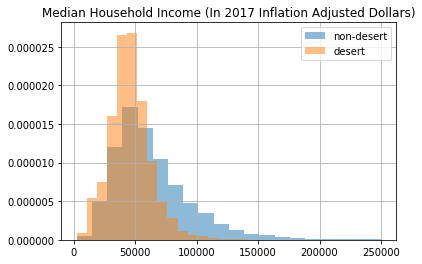

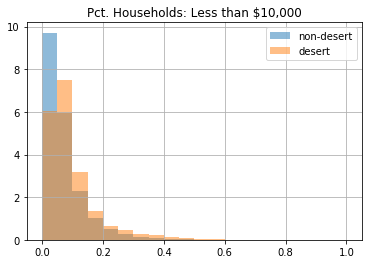

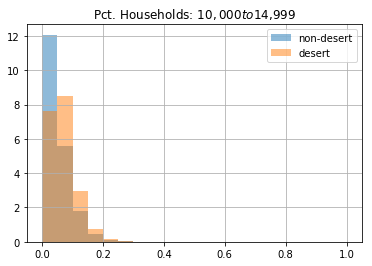

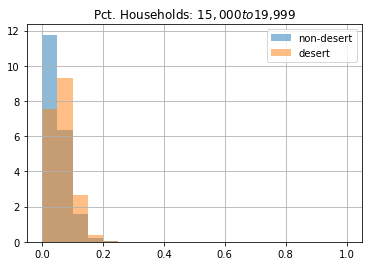

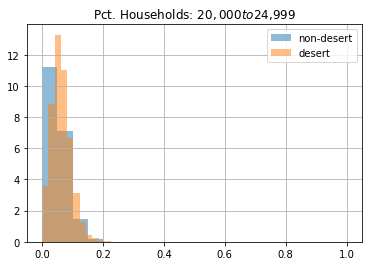

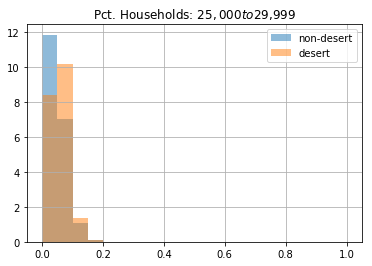

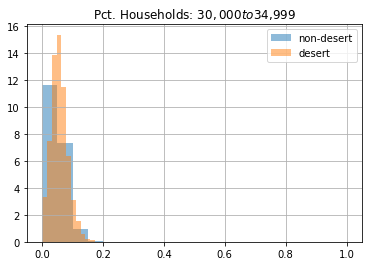

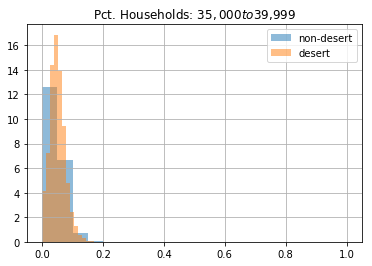

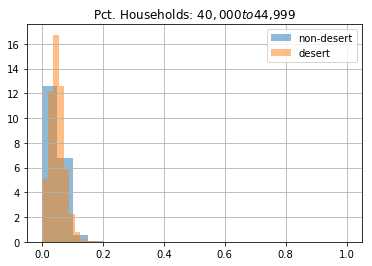

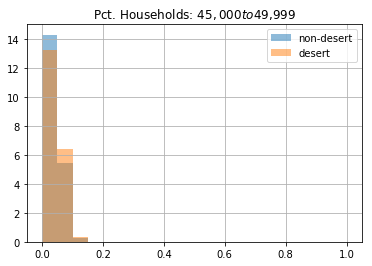

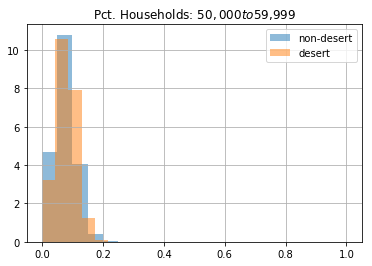

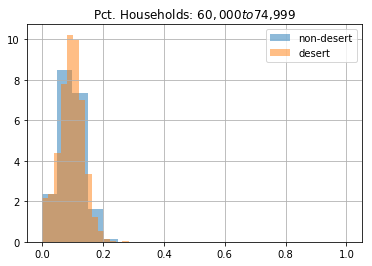

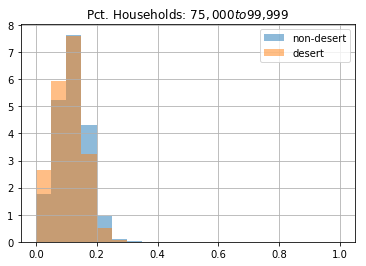

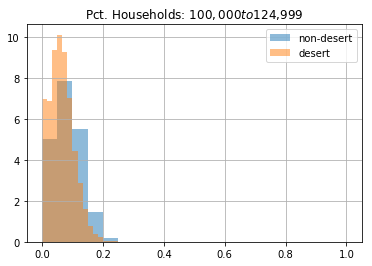

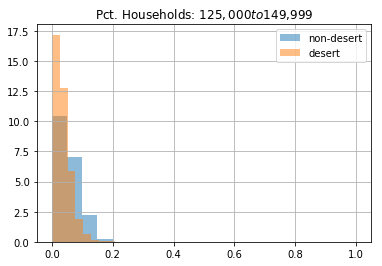

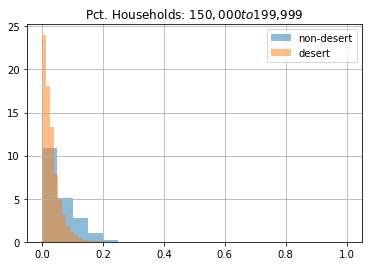

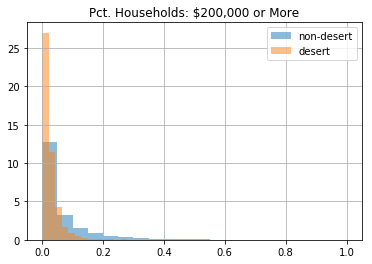

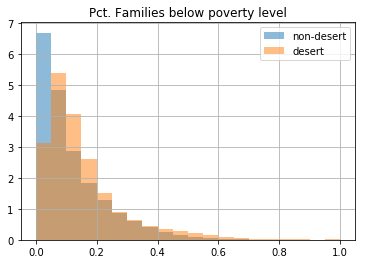

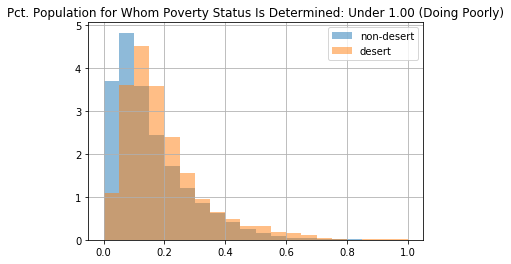

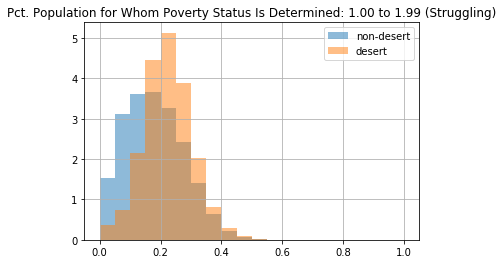

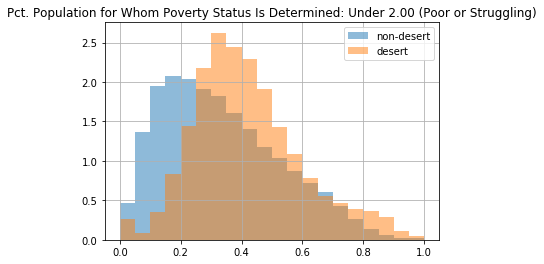

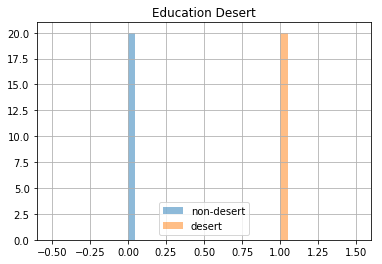

In [4]:
# Feature distributions, across education-deserts vs. non-education-deserts
for feat in X_nondesert.columns:
    non_desert_feat = X_nondesert[feat]
    desert_feat = X_desert[feat]
    plt.hist(non_desert_feat, bins=20, density=True, alpha=0.5, label='non-desert')
    plt.hist(desert_feat, bins=20, density=True, alpha=0.5, label='desert')
    plt.legend(loc='best')
    plt.grid()
    plt.title(feat)
    plt.show()

T-Test results:  Ttest_indResult(statistic=-61.28959990308626, pvalue=0.0)


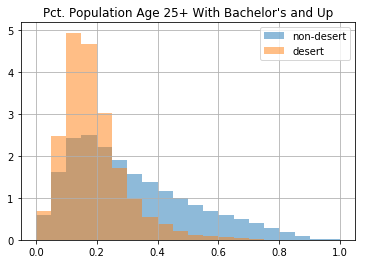

In [5]:
# Label histogram
from scipy.stats import ttest_ind
print('T-Test results: ', ttest_ind(y_desert, y_nondesert))

plt.hist(y_nondesert, bins=20, density=True, alpha=0.5, label='non-desert')
plt.hist(y_desert, bins=20, density=True, alpha=0.5, label='desert')
plt.legend(loc='best')
plt.grid()
plt.title("Pct. Population Age 25+ With Bachelor's and Up")
plt.show()

## Model Selection

In [6]:
# Ignore imblearn UserWarning
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
# from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from imblearn import FunctionSampler
from xgboost import XGBRegressor
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from collections import defaultdict

# Subsampler for GPR
# n_subsample = 1000
# def subsample(X, y):
#     idx = np.random.choice(np.arange(len(X)), n_subsample, replace=False)
#     return X[idx], y[idx]

# TODO: Use RandomizedSearchCV for hyperparameter tuning
models = {
    'LinearRegression': make_pipeline(StandardScaler(), LinearRegression()),
#     'PolyRegression': make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression()),
#     'SVR': make_pipeline(StandardScaler(), SVR(kernel='rbf')),
    'RandomForest': make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100)),
    'XGB': make_pipeline(StandardScaler(), XGBRegressor()),
#     'MLP': make_pipeline(StandardScaler(), MLPRegressor()),
#     'GaussianProcess': imblearn.pipeline.make_pipeline(StandardScaler(), FunctionSampler(subsample), GaussianProcessRegressor())
}

# Cross validation
metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = {}
for name, model in models.items():
    print('Evaluating {}... '.format(name))
#     results = cross_validate(model, X_nondesert, y_nondesert, cv=5, scoring=metrics, n_jobs=1)
#     results = cross_validate(model, X_all, y_all, cv=5, scoring=metrics, n_jobs=1)
    results = cross_validate(model, X_balanced.drop(['geoID'], axis=1), y_balanced, cv=5, scoring=metrics, n_jobs=1)
    cv_results[name] = results

# Convert CV results to Pandas dataframe
pd_results = defaultdict(dict)
for name, results in cv_results.items():
    test_metrics = ['test_' + metric for metric in metrics]
    for test_metric in test_metrics:
        pd_results[name][test_metric] = np.mean(results[test_metric])
    pd_results[name]['fit_time'] = np.mean(results['fit_time'])
        
# Display results
results_df = pd.DataFrame.from_dict(pd_results, orient='index')
results_df

Evaluating LinearRegression... 


/Users/lucashu/anaconda/envs/sony-ml/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Evaluating RandomForest... 
Evaluating XGB... 


,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,fit_time
LinearRegression,0.636569,-0.007098,-0.061520,0.076162
RandomForest,0.683131,-0.006015,-0.055305,63.159462
XGB,0.668743,-0.006263,-0.057017,5.811983


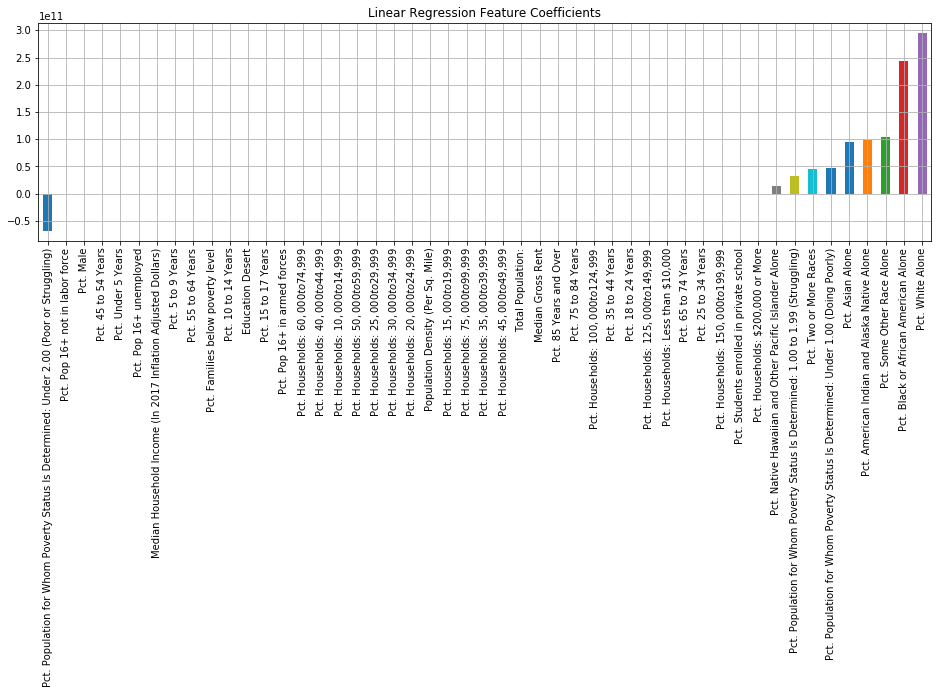

In [7]:
# Linear Regression Feature Coefficients
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
# models['LinearRegression'].fit(X_nondesert, y_nondesert)
models['LinearRegression'].fit(X_balanced.drop(['geoID'], axis=1), y_balanced)
rgr = models['LinearRegression'].named_steps['linearregression']
# coefs = pd.Series(rgr.coef_, index=X_nondesert.columns)
coefs = pd.Series(rgr.coef_, index=X_balanced.drop(['geoID'], axis=1).columns)
coefs = coefs.sort_values()
coefs.plot(kind="bar")
plt.grid()
plt.title('Linear Regression Feature Coefficients')
plt.show()

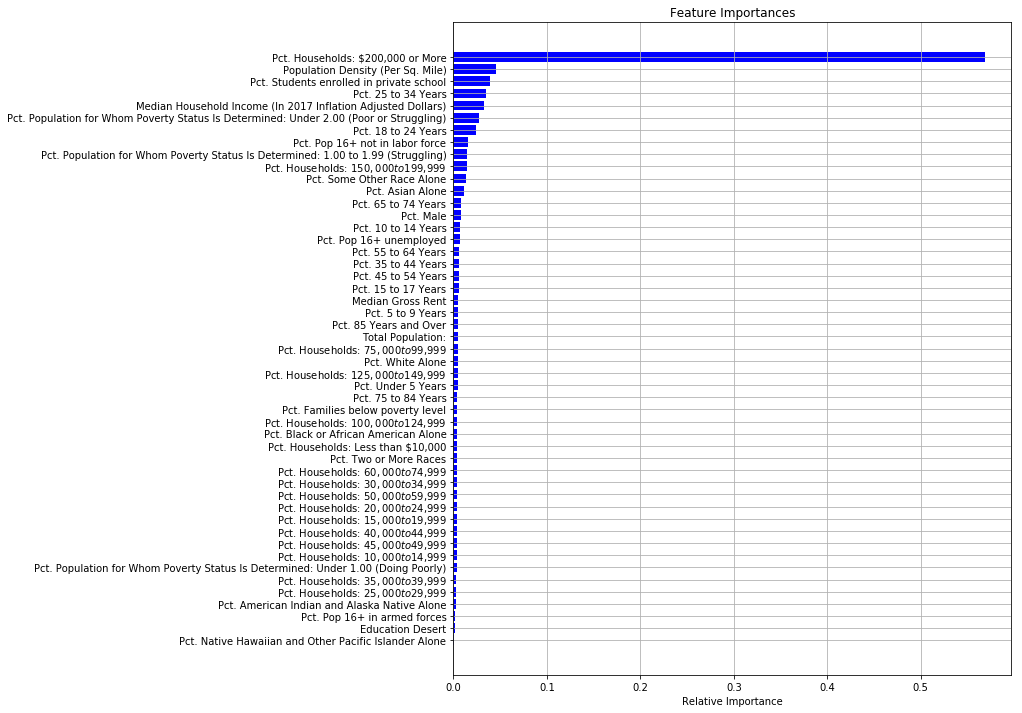

In [8]:
# Plot RF feature importances
models['RandomForest'].fit(X_balanced.drop(['geoID'], axis=1), y_balanced)
rf = models['RandomForest'].named_steps['randomforestregressor']

importances = rf.feature_importances_
# feat_names = X_nondesert.columns
feat_names = X_balanced.drop(['geoID'], axis=1).columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

# Plot top 10 features
# plt.figure(figsize=(10, 6))
# plt.title('XGB Regressor Feature Importances (Top 10 Features)')
# plt.barh(range(10), importances[indices[-10:]], color='b', align='center')
# plt.yticks(range(10), [feat_names[i] for i in indices[-10:]])
# plt.xlabel('Relative Importance')
# plt.grid()
# plt.show()

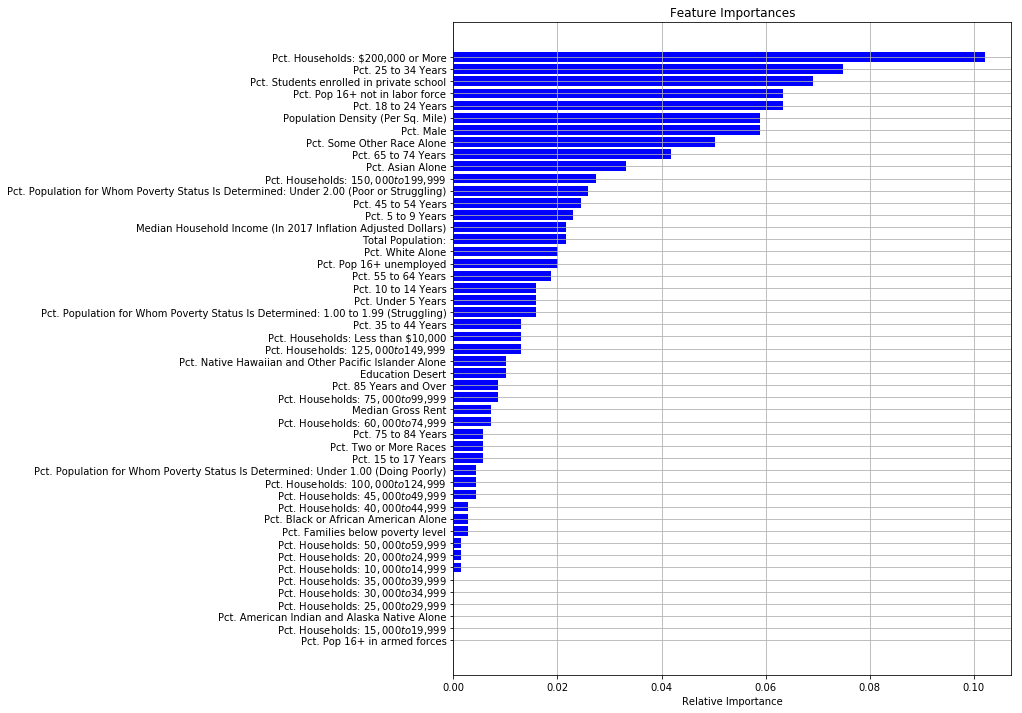

In [9]:
# Plot XGB feature importances
models['XGB'].fit(X_balanced.drop(['geoID'], axis=1), y_balanced)
xgb = models['XGB'].named_steps['xgbregressor']

importances = xgb.feature_importances_
# feat_names = X_nondesert.columns
feat_names = X_balanced.drop(['geoID'], axis=1).columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

# Plot top 10 features
# plt.figure(figsize=(10, 6))
# plt.title('XGB Regressor Feature Importances (Top 10 Features)')
# plt.barh(range(10), importances[indices[-10:]], color='b', align='center')
# plt.yticks(range(10), [feat_names[i] for i in indices[-10:]])
# plt.xlabel('Relative Importance')
# plt.grid()
# plt.show()

## Use Best Model

In [22]:
# Pick best model to use further
best_model = 'XGB'
model = models[best_model]

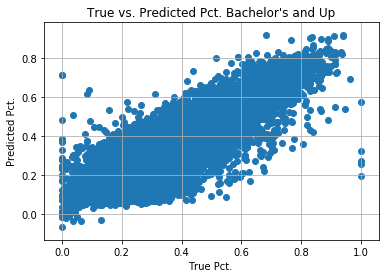

In [23]:
# True vs. Predicted Pct. Bachelor's and Up (On Non-Education Deserts)
from sklearn.model_selection import cross_val_predict
plt.scatter(y_balanced, cross_val_predict(model, X_balanced.drop(['geoID'], axis=1), y_balanced, cv=5))
plt.title("True vs. Predicted Pct. Bachelor's and Up")
plt.xlabel('True Pct. ')
plt.ylabel('Predicted Pct.')
plt.grid()

In [32]:
# # Re-fit, Serialize model
from joblib import dump, load
model.fit(X_balanced.drop(['geoID'], axis=1), y_balanced)
dump(model, '../models/{}_balanced.joblib'.format(best_model))
# model.fit(X_all.drop(['geoID'], axis=1), y_all)
# dump(model, '../models/{}.joblib'.format(best_model))

['../models/XGB_balanced.joblib']

Pct. Negative Predictions:  0.0
Prediction Range: [0.0, 0.7367380857467651]
Mean Prediction:  0.19162373
Median Prediction:  0.174184
Pct. Census Tracts where pct_bachelors_and_up Increased:  0.5641251221896383


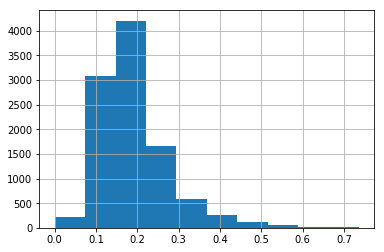

In [33]:
# Generate predictions on education deserts

clip = True # clip to 0, 1

# Generate pct_bachelors_and_up predictions on education deserts
# model.named_steps['standardscaler'].fit(X_deserts.drop(['geoID'], axis=1)) # rescale values to education deserts group
# y_pred_desert = pd.Series(model.predict(X_deserts.drop(['geoID'], axis=1)), name='pred_pct_bachelors_and_up')
# df_pred = pd.concat([X_deserts['geoID'].reset_index(drop=True), y_pred_desert.reset_index(drop=True)], axis=1)

y_pred_desert = pd.Series(model.predict(X_desert_intervention.drop(['geoID'], axis=1)),
                          name='pred_pct_bachelors_and_up')
df_pred = pd.concat([X_desert_intervention['geoID'].reset_index(drop=True),
                     y_pred_desert.reset_index(drop=True)], axis=1)

# Clip between (0, 1)
if clip:
    df_pred.loc[:, 'pred_pct_bachelors_and_up'] = np.clip(df_pred['pred_pct_bachelors_and_up'], 0, 1)
    y_pred_desert = np.clip(y_pred_desert, 0, 1)
    
assert df_pred.shape[0] == y_pred_desert.shape[0]

print('Pct. Negative Predictions: ', np.mean(y_pred_desert < 0))
print('Prediction Range: [{}, {}]'.format(y_pred_desert.min(), y_pred_desert.max()))
print('Mean Prediction: ', y_pred_desert.mean())
print('Median Prediction: ', y_pred_desert.median())
print('Pct. Census Tracts where pct_bachelors_and_up Increased: ', np.mean(y_pred_desert > y_desert))

y_pred_desert.hist()
plt.show()

Mean pct. difference:  0.24074727470681212
Median pct. difference:  0.720791485001307


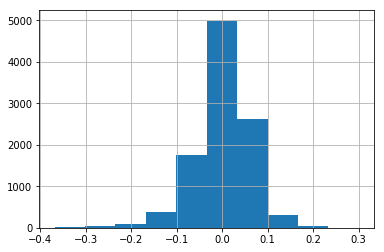

In [34]:
# Plot histogram of y_diffs (increase in pct_bachelors_and_up)
y_diffs = y_pred_desert - y_desert
print('Mean pct. difference: ', y_diffs.mean()*100)
print('Median pct. difference: ', y_diffs.median()*100)
y_diffs.hist()
plt.show()

In [35]:
# save results in CSV
df_pred.to_csv('../data/{}_pct_bachelors_predictions.csv'.format(best_model), 
                   header=['geoID', 'pred_pct_bachelors'], 
                   index=False)


In [16]:
# TODO:
# 1 decision tree
# normalize output
# try models that have (0, 1) output range - beta regression?
